# Projet Calibration

### Théo MIDAVAINE & Matthieu JULIEN

In [130]:
import math
import pandas as pd
import numpy as np
import random 
from tqdm import tqdm

from scipy.stats import norm
from scipy.optimize import minimize

import matplotlib.pyplot as plt

### I – Densités risque neutre 

1/ Sur les prix d’option données dans le tableau ci-après, calibrer une densité risque neutre en utilisant 
la formule de Breeden-Litzenberger et la technique de Shimko. Comparer avec une densité gaussienne. 

In [3]:
data = pd.DataFrame()
data["strikes"] = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
data["prices"] = [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]

In [4]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


def newton_raphson_implied_vol(row, S, r, initial_guess=0.2, T=1):     
    sigma = initial_guess     
    K = row['strikes']
    price_market = row['prices']  
    for _ in range(100):           
        d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        price_model = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)  
        vega = S * np.sqrt(T) * norm.pdf(d1)  
        price_diff = price_market - price_model  
        
        if np.abs(price_diff) < 1e-8:               
            return sigma                  
        sigma += price_diff / vega  # Mise à jour de sigma
        
        if sigma < 0:               
            sigma = 0.001     
    return sigma

def quadratic_interpolation(x_interpolated, x_original, y_original):
    y_interpolated = []
    for x in x_interpolated:
        for i in range(len(x_original) - 2):
            if x_original[i] <= x <= x_original[i + 2]:
                x1, x2, x3 = x_original[i], x_original[i + 1], x_original[i + 2]
                y1, y2, y3 = y_original[i], y_original[i + 1], y_original[i + 2]
                break

        A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [x3**2, x3, 1]])
        B = np.array([y1, y2, y3])
        a, b, c = np.linalg.solve(A, B)
        y = a*x**2 + b*x + c
        y_interpolated.append(y)

    return y_interpolated

In [18]:
T = 1 # On considère des calls 1 an
r = 0 # Risk free rate à 0
S0 = 100 # Spot price à T0 = 100

In [6]:
data["implied_vol"] = data.apply(lambda row: newton_raphson_implied_vol(row, S0, r, T=T), axis=1)
data

,strikes,prices,implied_vol
0,95,10.93,0.210948
1,96,9.55,0.189023
2,97,8.28,0.170031
3,98,7.40,0.160956
4,99,6.86,0.160079
5,100,6.58,0.165124
6,101,6.52,0.175031
7,102,6.49,0.185098
8,103,6.47,0.194908
9,104,6.46,0.204530


In [7]:
print('Prix théorique avec la volatilité implicite calculée par NewtonRaphson : ', black_scholes_call_price(S0, 95, T, r, data[data['strikes'] == 95]['implied_vol'].values))
print('Prix de marché :', data[data['strikes'] == 95]['prices'].values)


Prix théorique avec la volatilité implicite calculée par NewtonRaphson :  [10.93]
Prix de marché : [10.93]


Interpolation des volatilités implicites

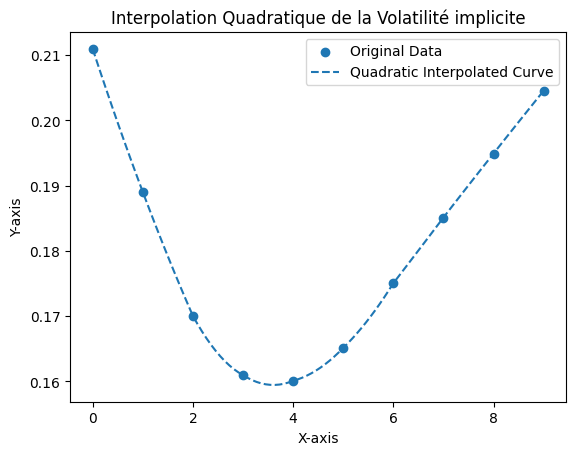

In [8]:
x_original = np.array(data.index)
y_original = np.array(data["implied_vol"])

nb_pts = 100
x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
vol_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, vol_interpolated, label='Quadratic Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Interpolation Quadratique de la Volatilité implicite')
plt.show()

Interpolation des strikes

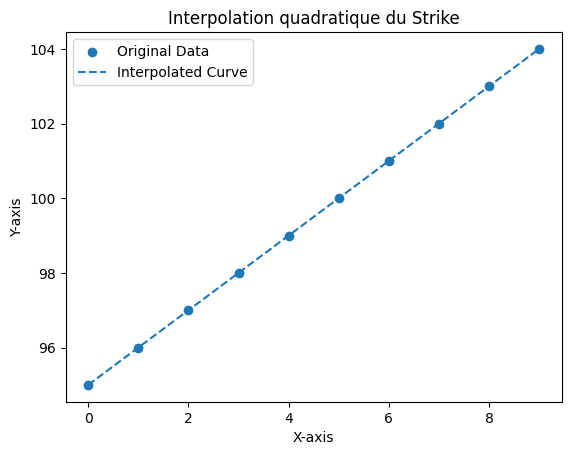

In [9]:
x_original=data.index
y_original=data["strikes"]
nb_pts=100
x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, strike_interpolated, label='Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Interpolation quadratique du Strike')
plt.show()

Calcul des prix avec Black-Scholes avec les vol et strike interpolés

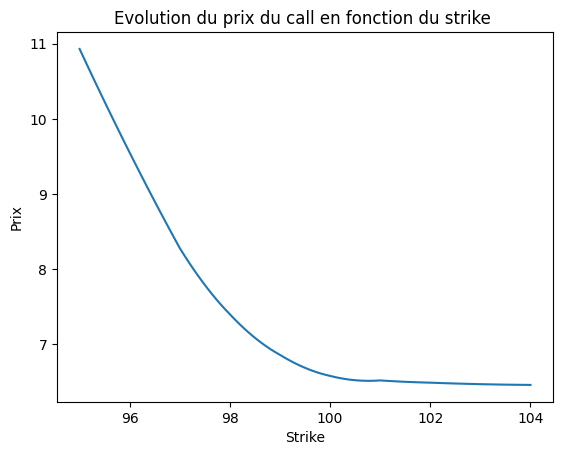

In [10]:
prices=[]

for i,j in zip(strike_interpolated,vol_interpolated):
    prices.append(black_scholes_call_price(S0,i,T,r,j))

df=pd.DataFrame([prices,strike_interpolated],index=["Price","Strike"]).T
plt.plot(np.array(df["Strike"]),np.array(df["Price"]))
plt.title("Evolution du prix du call en fonction du strike ")
plt.ylabel("Prix")
plt.xlabel("Strike")
plt.show()

In [20]:
def neutral_risk_density(strikes , r , S0 , T , implied_vols ) :
    density = np.zeros(len(strikes))
    k=df["Strike"][1]-df["Strike"][0]
    
    for i , K in enumerate (strikes) :
        C_plus_k = black_scholes_call_price (S0 , K + k , T , r , implied_vols[i] ) 
        C_minus_k = black_scholes_call_price (S0 , K - k , T , r , implied_vols[i] ) 
        C_actuel = black_scholes_call_price (S0 , K , T , r , implied_vols[i] )

        # Formule de Breeden - Litzenberger 
        density [ i ] = np.exp( r * T ) *(( C_plus_k - 2 * C_actuel + C_minus_k ) / k ** 2)

    return density

density_risque_neutre = neutral_risk_density (strike_interpolated , r , S0 , T , vol_interpolated )

In [21]:
def gaussian(x, mu, sigma, ratio):
    return ratio * np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def objective(params, x, data):
    mu, sigma, ratio = params
    return np.sum((gaussian(x, mu, sigma, ratio) - data)**2)

initial_guess = [100, 5, 2]

result = minimize(objective, initial_guess, args=(df["Strike"], density_risque_neutre))

fitted_mu, fitted_sigma, fitted_ratio = result.x

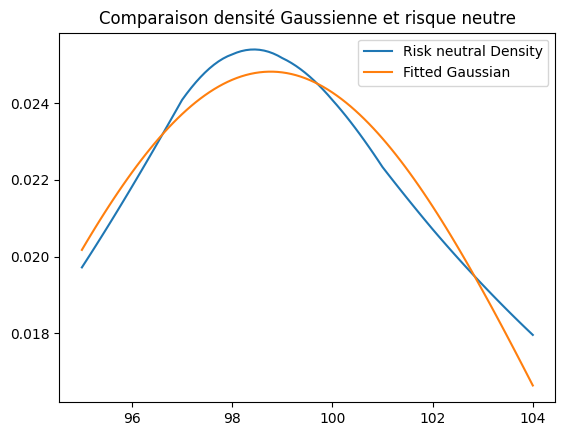

Fitted Mean: 98.7674639939289
Fitted Standard Deviation: 5.854576279872189
Fitted Amplitude (Ratio): 0.364191517778908


In [22]:
plt.plot(df["Strike"], density_risque_neutre, label='Risk neutral Density')
plt.plot(df["Strike"], gaussian(df["Strike"], fitted_mu, fitted_sigma, fitted_ratio), label='Fitted Gaussian')
plt.title( "Comparaison densité Gaussienne et risque neutre")
plt.legend()
plt.show()

print("Fitted Mean:", fitted_mu)
print("Fitted Standard Deviation:", fitted_sigma)
print("Fitted Amplitude (Ratio):", fitted_ratio)

2/ Vérifier, en faisant des tirages dans cette loi implicite, si l’on trouve un prix de modèle proche du 
prix de marché pour toutes les options ci-dessus. 

In [23]:
# Simulation Monte Carlo pour valoriser une option
def valorisation_MC(S, K, T, r, pas, sigma,nb_simulations):
    dt=T/pas
    paths = np.zeros((nb_simulations, pas + 1))   #on créé une matrice de taille nb_simulations x pas
    paths[:, 0] = S   #on remplit la première valeur de chaque ligne avec le spot
    
    for i in range(pas):
        paths[:, i + 1] = paths[:, i] *np.exp(dt*(r - 0.5*sigma**2) + sigma*np.sqrt(dt)* ((np.random.normal(fitted_mu,fitted_sigma,size=nb_simulations)-fitted_mu)/fitted_sigma))   #tirage dans notre loi implicite
        #pour chaque pas on calcule le prix future en utilisant le spot précédent
    option_payoffs = np.maximum(paths[:, -1] - K, 0)     #on prend ensuite le max entre notre dernier spot futur calculé - strike et 0
    option_value = np.exp(-r * T) * np.mean(option_payoffs)  # on calcule la moyenne des payoffs qu'on actualise
    
    return option_value

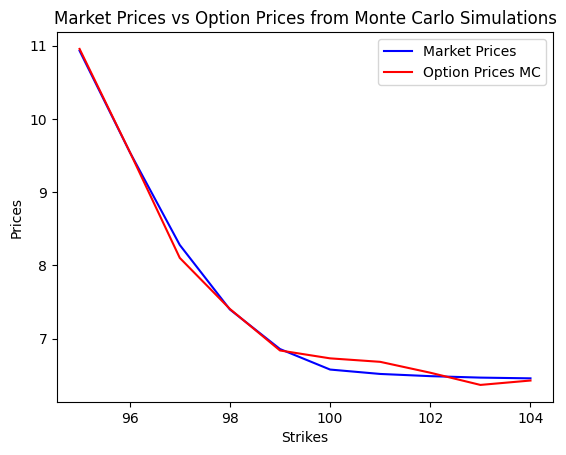

In [135]:
option_prices_mc = [valorisation_MC(S0, strike, T, r, 252, vol, 10000) for strike, vol in zip(data["strikes"], data["implied_vol"])]

fig, ax = plt.subplots()

# Plot the data
ax.plot(data["strikes"], data["prices"], label='Market Prices', color='blue')
ax.plot(data["strikes"], option_prices_mc, label='Option Prices MC', color='red')

ax.set_xlabel('Strikes')
ax.set_ylabel('Prices')
ax.set_title('Market Prices vs Option Prices from Monte Carlo Simulations')
ax.legend()

plt.show()


In [25]:
for strike,vol,market_price,mc_price in zip(data["strikes"],data["implied_vol"],data["prices"],option_prices_mc):
    print(f"Option : K = {strike}, Sigma = {vol:.2f}")
    print(f"Prix par simulation de Monte Carlo = {mc_price:.2f}")
    print(f"Market Price = {market_price:.2f}\nDifference = {abs(mc_price-market_price):.2f}\n")


Option : K = 95, Sigma = 0.21
Prix par simulation de Monte Carlo = 11.02
Market Price = 10.93
Difference = 0.09

Option : K = 96, Sigma = 0.19
Prix par simulation de Monte Carlo = 9.45
Market Price = 9.55
Difference = 0.10

Option : K = 97, Sigma = 0.17
Prix par simulation de Monte Carlo = 8.38
Market Price = 8.28
Difference = 0.10

Option : K = 98, Sigma = 0.16
Prix par simulation de Monte Carlo = 7.48
Market Price = 7.40
Difference = 0.08

Option : K = 99, Sigma = 0.16
Prix par simulation de Monte Carlo = 7.03
Market Price = 6.86
Difference = 0.17

Option : K = 100, Sigma = 0.17
Prix par simulation de Monte Carlo = 6.62
Market Price = 6.58
Difference = 0.04

Option : K = 101, Sigma = 0.18
Prix par simulation de Monte Carlo = 6.44
Market Price = 6.52
Difference = 0.08

Option : K = 102, Sigma = 0.19
Prix par simulation de Monte Carlo = 6.33
Market Price = 6.49
Difference = 0.16

Option : K = 103, Sigma = 0.19
Prix par simulation de Monte Carlo = 6.64
Market Price = 6.47
Difference = 0

## II – Interpolation et volatilité locale

En plus du tableau donné précédemment, on va utiliser pour cette partie les prix d’options suivants <br>
On utilise la fonction d'interpolation quadratique, pour lisser la courbe

In [28]:
def interpolation(data,T):
    prices = []
    #interpolation of vol
    x_original = np.array(data.index)
    y_original = np.array(data["implied_vol"])
 
    nb_pts = 100
    x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
    y_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)
 
    #interpolation of strikes
    x_original=data.index
    y_original=data["strikes"]
    x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
    strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)
 
    #Calcul des prix avec la formule de black scholes en fonction des paramêtres interpolés
    for i,j in zip(strike_interpolated,y_interpolated):
        prices.append(black_scholes_call_price(S0,i,T,r,j))
   
    df=pd.DataFrame([prices,strike_interpolated,y_interpolated],index=["prices","strikes",'implied_vol']).T
    return df

In [29]:
data_12_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                'prices': [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]}
data_9_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices':[11.79 ,8.95 ,8.07 ,7.03 ,6.18 ,6.04 ,5.76 ,5.50 ,5.50 ,5.39]}
data_6_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                    'prices': [10.71 ,8.28 ,6.91 ,6.36 ,5.29 ,5.07 ,4.76 ,4.47 ,4.35 ,4.14]}
data_3_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices': [8.67, 7.14, 5.98, 4.93, 4.09, 3.99, 3.43, 3.01, 2.72, 2.53]}

df_12_months = pd.DataFrame(data_12_months)
df_9_months = pd.DataFrame(data_9_months)
df_6_months = pd.DataFrame(data_6_months)
df_3_months = pd.DataFrame(data_3_months)


df_12_months_10v = pd.DataFrame(data_12_months)
df_9_months_10v = pd.DataFrame(data_9_months)
df_6_months_10v = pd.DataFrame(data_6_months)
df_3_months_10v = pd.DataFrame(data_3_months)



# On utilise l'algorithme de Newton Raphson pour trouver les volatilités implicites

df_12_months["implied_vol"] = df_12_months.apply(lambda row: newton_raphson_implied_vol(row, S0, r, 1), axis=1)
df_9_months["implied_vol"] = df_9_months.apply(lambda row: newton_raphson_implied_vol(row, S0, r, 9/12), axis=1)
df_6_months["implied_vol"] = df_6_months.apply(lambda row: newton_raphson_implied_vol(row, S0, r, 6/12), axis=1)
df_3_months["implied_vol"] = df_3_months.apply(lambda row: newton_raphson_implied_vol(row, S0, r, 3/12), axis=1)


df_12_months = interpolation(df_12_months,1)
df_9_months = interpolation(df_9_months,0.75)
df_6_months = interpolation(df_6_months,0.5)
df_3_months = interpolation(df_3_months,0.25)

df_12_months['maturité'] =  [1]*100
df_9_months['maturité'] = [0.75]*100
df_6_months['maturité'] = [0.5]*100
df_3_months['maturité'] = [0.25]*100


df_concatenated = pd.concat([df_12_months,df_9_months, df_6_months, df_3_months])
df_concatenated.reset_index(drop=True,inplace=True)

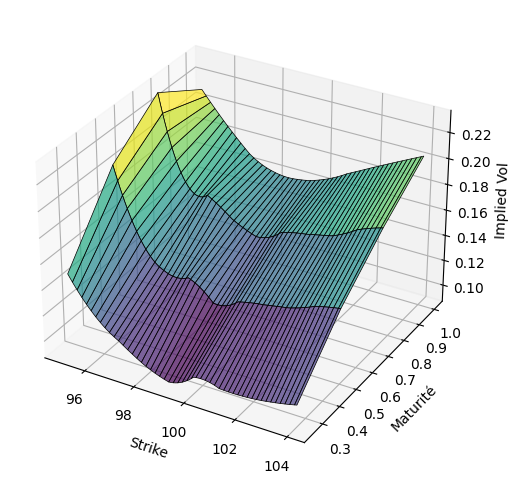

In [35]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Utilisation de plot_surface
ax.plot_surface(df_concatenated['strikes'].values.reshape(4, -1),
                df_concatenated['maturité'].values.reshape(4, -1),
                df_concatenated['implied_vol'].values.reshape(4, -1),
                cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.7)

# Configurations supplémentaires
ax.set_xlabel('Strike')
ax.set_ylabel('Maturité')
ax.set_zlabel('Implied Vol')
# ax.view_init(azim=90)
plt.show()

Proposer un prix, le plus juste 
possible, pour une option de strike 99.50 et de maturité 8 mois (justifier la méthode retenue). 

In [36]:
def quadratic_interpolation(x_interpolated, x_original, y_original):
    y_interpolated = []
    for x in x_interpolated:
        for i in range(len(x_original) - 2):
            if x_original[i] <= x <= x_original[i + 2]:
                x1, x2, x3 = x_original[i], x_original[i + 1], x_original[i + 2]
                y1, y2, y3 = y_original[i], y_original[i + 1], y_original[i + 2]
                break

        A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [x3**2, x3, 1]])
        B = np.array([y1, y2, y3])
        a, b, c = np.linalg.solve(A, B)
        y = a*x**2 + b*x + c
        y_interpolated.append(y)

    return y_interpolated

On test l'interpolation quadratique avec une valeur que l'on connait pour estimer son erreur.<br>
Ici avec un Call K=99 T=1

In [ ]:
volatility_interpolated = quadratic_interpolation([99], data["strikes"], data["implied_vol"])

print('K = 99')
print(f"The interpolated volatility = {volatility_interpolated[0]:.4f}")
print(f"Implied vol = {float(data[data['strikes']==99]['implied_vol'].values):.4f}")

K = 99
The interpolated volatility = 0.1601
Implied vol = 0.1601


In [ ]:
y_interpolated = quadratic_interpolation([8/12], [0.25, 0.5, 0.75, 1], list(df_concatenated['implied_vol']))
 
print('K = 99.50 and T = 8/12')
print(f"Implied vol interpolated : {y_interpolated[0]:.4f}")

K = 99.50 and T = 8/12
Implied vol interpolated : 0.2074


We will use interp2d as a benchmark to test our functions

In [ ]:
from scipy.interpolate import interp2d
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
strike_prices = list(df_concatenated[df_concatenated['maturité']==1]['strikes'])
maturities = [0.5, 0.75]

implied_volatilities = [
    list(df_6_months['implied_vol'].values),
    list(df_9_months['implied_vol'].values)  
]

interp_func = interp2d(strike_prices, maturities, implied_volatilities, kind='linear')

x_target = 99.5
z_target = 8/12

implied_volatility_8_12 = interp_func(x_target, z_target)

print(f"Implied Volatility for maturity 8/12 and strike 99.5: {implied_volatility_8_12[0]:.4f}")

Implied Volatility for maturity 8/12 and strike 99.5: 0.1371


We remark that the error is too big, and the quadratic interpolation function is not adapted to fit both interpolated strikes and maturity, so we will use the bilinear interpolation which is more adapted to interpolate 2 parameters

In [ ]:
def bilinear_interpolation(x, y, points):
# Fvoir sur https ://fr.wikipedia.org/wiki/Interpolation_bilin%C3%A9aire
    points = sorted(points)
    (x1 , y1 , q11), (_x1 , y2, q12), (x2, _y1 , q21), (_x2 , _y2 , q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError("points do not form a rectangle")
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError("(x, y) not within the rectangle ")

    return (q11 * (x2 - x) * (y2 - y) +
    q21 * (x - x1) * (y2 - y) +
    q12 * (x2 - x) * (y - y1) +
    q22 * (x - x1) * (y - y1)) / ((x2 - x1) * (y2 - y1) + 0.0)

In [ ]:
x_val = 99
y_val = 1
z_val = bilinear_interpolation(x_val,y_val,[(98,0.75,float(df_9_months[df_9_months['strikes'] == 98]['implied_vol'].values)),
                                            (98,1,float(df_12_months[df_12_months['strikes'] == 98]['implied_vol'].values)),
                                        (100,0.75,float(df_9_months[df_9_months['strikes'] == 100]['implied_vol'].values)),
                                        (100,1,float(df_12_months[df_12_months['strikes'] == 100]['implied_vol'].values))])

In [ ]:
true_z_val = float(df_12_months[df_12_months['strikes']==99]['implied_vol'].values)
print(f'Implied vol from the dataframe : {true_z_val:.4f}')
print(f'Bilinear interpolated implied vol : {z_val:.4f}')
print(f'The error between bilinear interpolation and true value is : {abs(true_z_val - z_val):.4f}')

Implied vol from the dataframe : 0.1601
Bilinear interpolated implied vol : 0.1630
The error between bilinear interpolation and true value is : 0.0030


In [ ]:
t1 = float(df_concatenated[(df_concatenated['strikes'] == 99) & (df_concatenated['maturité'] == 1)]['prices'].values)
print(f'Market Price: {t1:.4f}')
t2 = black_scholes_call_price(100,99,1,0,z_val)
print(f'BS Call price with bilinear interpolated implied vol : {t2:.4f}')
print(f'The error is {abs(t1-t2):.4f} or {abs((t1-t2)/t1):.4f}%')

Market Price: 6.8600
BS Call price with bilinear interpolated implied vol : 6.9769
The error is 0.1169 or 0.0170%


We consider the error is acceptable so we will go with this method

In [ ]:
x_val = 99.5
y_val = 8/12
z_995_val = bilinear_interpolation(x_val,y_val,[(99,0.75,float(df_9_months[df_9_months['strikes'] == 98]['implied_vol'].values)),
                                        (99,0.5,float(df_6_months[df_6_months['strikes'] == 98]['implied_vol'].values)),
                                        (100,0.75,float(df_9_months[df_9_months['strikes'] == 100]['implied_vol'].values)),
                                        (100,0.5,float(df_6_months[df_6_months['strikes'] == 100]['implied_vol'].values))
                                        ]                 
                               )

In [ ]:
print(f'Implied vol from interp2d : {implied_volatility_8_12[0]:.4f}')
print(f'Bilinear interpolated implied vol : {z_995_val:.4f}')
print(f'The error between bilinear interpolation and true value is : {abs(implied_volatility_8_12[0] - z_995_val):.4f}')


prix_quad = black_scholes_call_price(100,99.5,8/12,0,y_interpolated[0])
print(f"Prix trouvé avec l'interpolation quadratique : {prix_quad:.4f}")
prix_bi = black_scholes_call_price(100,99.5,8/12,0,z_995_val)
print(f"Prix trouvé avec l'interpolation bilinéeaire : {prix_bi:.4f}")
prix_interp2d = black_scholes_call_price(100,99.5,8/12,0,implied_volatility_8_12[0])
print(f"Prix théorique dans le dataframe: {prix_interp2d:.4f}")

Implied vol from interp2d : 0.1371
Bilinear interpolated implied vol : 0.1446
The error between bilinear interpolation and true value is : 0.0075
Prix trouvé avec l'interpolation quadratique : 6.9850
Prix trouvé avec l'interpolation bilinéeaire : 4.9494
Prix théorique dans le dataframe: 4.7066


4/ Calibrer un modèle à volatilité locale de type SVI en suivant les étapes suivantes : 
-  écrire l’algorithme de valorisation d’une option avec le modèle SVI, par EDP d’une part et par 
Monte Carlo d’autre part et comparer les résultats pour plusieurs jeux de paramètres ; 
-  estimez les cinq paramètres permettant de réduire au plus l’erreur moyenne ; 
-  on fixe tous les paramètres aux valeurs estimées ci-avant (sauf a et b) et on va calibrer les deux 
paramètres a et b pour chaque option : vous obtiendrez donc une nappe pour chacun de ces 
deux paramètres et vous introduirez une contrainte de régularisation de ces deux nappes dans 
votre problème d’optimisation.

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>σ</mi><mo stretchy="false">(</mo><mi>K</mi><mo stretchy="false">)</mo><mo>=</mo><msqrt><mrow><mi>a</mi><mo>+</mo><mi>b</mi><mrow><mo fence="true">[</mo><mi>ρ</mi><mo stretchy="false">(</mo><mi>K</mi><mo>−</mo><mi>m</mi><mo stretchy="false">)</mo><mo>+</mo><msqrt><mrow><mo stretchy="false">(</mo><mi>K</mi><mo>−</mo><mi>m</mi><msup><mo stretchy="false">)</mo><mn>2</mn></msup><mo>+</mo><msup><mi>σ</mi><mn>2</mn></msup></mrow></msqrt><mo fence="true">]</mo></mrow></mrow></msqrt></mrow><annotation encoding="application/x-tex">\sigma(K) = \sqrt{a + b \left[ \rho (K - m) + \sqrt{(K - m)^2 + \sigma^2} \right]}
</annotation></semantics></math>

Où :

σ(K) est la volatilité implicite en fonction du prix d’exercice K.<br>
a, b, ρ, m et σ sont les paramètres du modèle SVI.<br>
a est le niveau de volatilité à la maturité.<br>
b est la pente de la volatilité en fonction du prix d’exercice.<br>
ρ est le paramètre d’asymétrie.<br>
m est le prix d’exercice auquel la volatilité est minimale.<br>
σ est la volatilité de la volatilité.<br>

In [154]:
def log_moneyness(St,S0):
    return np.log(St/S0) # Forward = S0 car r = 0

def svi_cal(param,x):    
    return (param[0] + param[1] * (param[2] * (x - param[3]) + np.sqrt((x - param[3])**2 + param[4]**2)))

In [160]:
def MonteCarlo(S0,T,r,nb_pas,nb_paths,param):
    dt = T/nb_pas
    paths = np.zeros((nb_paths, nb_pas + 1))
    paths[:, 0] = S0  
    for i in range(nb_pas):
        x = log_moneyness(paths[:, i],S0)
        z = np.random.standard_normal(size=nb_paths)
        implied_vol = svi_cal(param, x)   #A chaque pas on calcule notre volatilité avec le modèle SVI
        paths[:, i+1] = paths[:, i] * np.exp((r-0.5 * implied_vol) * dt + np.sqrt(dt*implied_vol) * z)
    
    return paths

def Valo_MC(S0,K,T,r,nb_pas,nb_paths,param):
    paths = MonteCarlo(S0,T,r,nb_pas,nb_paths,param)
    option_payoffs = np.maximum(paths[:, -1] - K, 0)
    option_value = np.exp(-r * T) * np.mean(option_payoffs)  #payoff actualisé

    return option_value

In [198]:
def error_function(param,data):
    true_prices = data["prices"]
    simulated_prices = [Valo_MC(S0, K, 1,r, 100, 5000,param) for K in data["strikes"]]
    error = np.sum((np.array(simulated_prices) - np.array(true_prices))**2)
    return error

In [199]:
optimal_param

array([0.0057285 , 0.18223848, 0.14305675, 0.11772247, 0.09777798])

In [207]:
tab_param  = []
while result.fun > 0.5:
    param_initial = optimal_param
    result = minimize(error_function, param_initial, df_12_months_10v, method='Nelder-Mead')
    optimal_param = result.x
    tab_param.append((optimal_param,result.fun))
    print(result)

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 3.108785211470153
             x: [ 5.874e-03  1.891e-01  1.452e-01  1.215e-01  9.663e-02]
           nit: 377
          nfev: 1000
 final_simplex: (array([[ 5.874e-03,  1.891e-01, ...,  1.215e-01,
                         9.663e-02],
                       [ 5.874e-03,  1.891e-01, ...,  1.215e-01,
                         9.663e-02],
                       ...,
                       [ 5.874e-03,  1.891e-01, ...,  1.215e-01,
                         9.663e-02],
                       [ 5.874e-03,  1.891e-01, ...,  1.215e-01,
                         9.663e-02]]), array([ 3.109e+00,  4.792e+00,  4.873e+00,  4.879e+00,
                        4.900e+00,  5.400e+00]))
       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 3.0592309163599927
             x: [ 5.783e-03  1.937e-01  1.476e

KeyboardInterrupt: 

In [208]:
tab_param

[(array([0.00587439, 0.18909573, 0.14524511, 0.12145027, 0.09662839]),
  3.108785211470153),
 (array([0.00578321, 0.19371811, 0.14759935, 0.11698491, 0.09902243]),
  3.0592309163599927),
 (array([0.00583693, 0.19586617, 0.1489703 , 0.11807159, 0.10006592]),
  3.4034415023515976),
 (array([0.00589381, 0.19513183, 0.15042321, 0.12217454, 0.1010416 ]),
  3.525803294010507),
 (array([0.0059023 , 0.19508088, 0.15787326, 0.12217751, 0.10100038]),
  3.235881931596078),
 (array([0.00575604, 0.19701294, 0.15943384, 0.12646399, 0.10200115]),
  3.6201930783427043),
 (array([0.00591721, 0.20252931, 0.15624504, 0.13000495, 0.09771716]),
  3.9611654924569306),
 (array([0.00560091, 0.20584742, 0.15820375, 0.13238099, 0.10000763]),
  4.069883390824329),
 (array([0.00556858, 0.19240897, 0.16379967, 0.1352106 , 0.10073238]),
  3.675964107557344),
 (array([0.00572545, 0.18858177, 0.16835173, 0.13895787, 0.09653664]),
  3.3533428098145732),
 (array([0.00590134, 0.18839408, 0.16910955, 0.13916444, 0.097732

In [204]:
optimal_param = result.x
result

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 3.200465180461327
             x: [ 5.846e-03  1.869e-01  1.410e-01  1.201e-01  9.733e-02]
           nit: 373
          nfev: 1000
 final_simplex: (array([[ 5.846e-03,  1.869e-01, ...,  1.201e-01,
                         9.733e-02],
                       [ 5.846e-03,  1.869e-01, ...,  1.201e-01,
                         9.733e-02],
                       ...,
                       [ 5.846e-03,  1.869e-01, ...,  1.201e-01,
                         9.733e-02],
                       [ 5.846e-03,  1.869e-01, ...,  1.201e-01,
                         9.733e-02]]), array([ 3.200e+00,  3.885e+00,  4.519e+00,  4.596e+00,
                        4.600e+00,  5.618e+00])) [0.00584639 0.18690014 0.14095381 0.1201452  0.09732625]


In [205]:
result.x

array([0.00584639, 0.18690014, 0.14095381, 0.1201452 , 0.09732625])

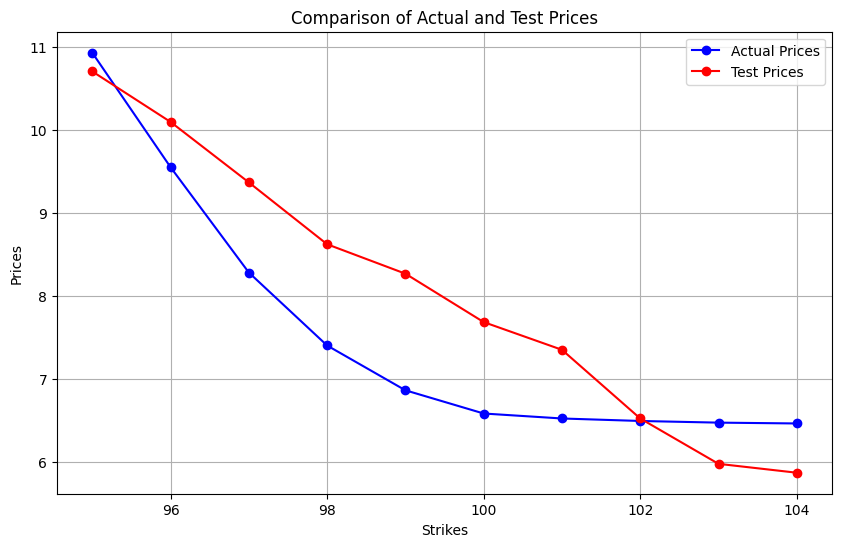

In [203]:
# Option parameters
S0 = 100
K = 100
T = 1
r = 0

# Monte Carlo parameters
nb_pas = 100
nb_paths = 10000


init_param = optimal_param

test_prices = []
for i in range(94,104):
    test2 = Valo_MC(S0,i,T,r,nb_pas,nb_paths,init_param)
    test_prices.append(test2)

plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(data['strikes'], data['prices'],'o-', label='Actual Prices', color='b')
plt.plot(data['strikes'], test_prices, 'o-',label='Test Prices', color='r')

# Add labels and title
plt.xlabel('Strikes')
plt.ylabel('Prices')
plt.title('Comparison of Actual and Test Prices')

# Add a legend
plt.legend()

# Add gridlines
plt.grid(True)

plt.show()
